# Demo Word2Vec

Using FastText for optimal word vectorization as opposed to one hot encoding.

## Load Vectorizer

In [1]:
VOCAB_SIZE = 100000
UNK = VOCAB_SIZE
PAD = VOCAB_SIZE + 1

In [2]:
def _count_generator(reader):
    b = reader(1024 * 1024)
    while b:
        yield b
        b = reader(1024 * 1024)

def num_lines(path):
    with open(path, 'rb') as fp:
        c_generator = _count_generator(fp.raw.read)
        # count each \n
        count = sum(buffer.count(b'\n') for buffer in c_generator)
        return count + 1

# Code from https://fasttext.cc/docs/en/english-vectors.html
# Modified to use a limited vocabulary size and have a progress bar
import io
from tqdm import tqdm as tqdm
import numpy as np

def load_vectors(fname):
    # lines = num_lines(fname)
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    # for line in tqdm(fin, total=lines):
    for idx, line in tqdm(enumerate(fin), total=VOCAB_SIZE):
        if idx >= VOCAB_SIZE:
            break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.array(list(map(float, tokens[1:])) + [0, 0])
    return data

In [3]:
vectorizer = load_vectors('wiki-news-300d-1M-subword-fasttext/wiki-news-300d-1M-subword.vec')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:03<00:00, 29005.85it/s]


In [4]:
def vectorize(word) -> np.ndarray:
    if word == '':  # If this is a pad token
        return np.array([0] * 301 + [1], dtype=np.float64)
    if word in vectorizer:  # If this word is in our vocabulary
        return vectorizer[word]
    return np.array([0] * 300 + [1, 0], dtype=np.float64)  # Unknown token

## Load Data/Preprocess

In [5]:
import pandas as pd
data = pd.read_csv('out.csv')
data

,Unnamed: 0,lastfm_url,track,artist,seeds,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,mbid,spotify_id,genre,Lyric,language
0,1,https://www.last.fm/music/metallica/_/st.%2banger,St. Anger,Metallica,['aggressive'],8,3.710000,5.833000,5.427250,727a2529-7ee8-4860-aef6-7959884895cb,3fOc9x06lKJBhz435mInlH,metal,Saint Anger 'round my neck\nSaint Anger 'round...,en
1,3,https://www.last.fm/music/m.i.a./_/bamboo%2bbanga,Bamboo Banga,M.I.A.,"['aggressive', 'fun', 'sexy', 'energetic']",13,6.555071,5.537214,5.691357,99dd2c8c-e7c1-413e-8ea4-4497a00ffa18,6tqFC1DIOphJkCwrjVzPmg,hip-hop,"Road runner, road runner\nGoing hundred mile p...",en
2,5,https://www.last.fm/music/drowning%2bpool/_/st...,Step Up,Drowning Pool,['aggressive'],9,2.971389,5.537500,4.726389,49e7b4d2-3772-4301-ba25-3cc46ceb342e,4Q1w4Ryyi8KNxxaFlOQClK,metal,Come!\n\nIf our own lives aren’t directly affe...,en
3,11,https://www.last.fm/music/kanye%2bwest/_/feedback,Feedback,Kanye West,['aggressive'],1,3.080000,5.870000,5.490000,NaN,49fT6owWuknekShh9utsjv,hip-hop,"Ayy, y'all heard about the good news?\nY'all s...",en
4,13,https://www.last.fm/music/deftones/_/7%2bwords,7 Words,Deftones,"['aggressive', 'angry']",10,3.807121,5.473939,4.729091,1a826083-5585-445f-a708-415dc90aa050,6DoXuH326aAYEN8CnlLmhP,nu metal,"I'll never be the same, breaking decency\nDon'...",en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,229432,https://www.last.fm/music/noblegases/_/xenon,Xenon,NobleGases,['noble'],2,6.160000,3.695000,6.130000,NaN,1AePjgLLtzF0abbfcgYdLI,chill,You're floating out astray\nThis cold and life...,en
16793,229435,https://www.last.fm/music/kurt%2bvile/_/wild%2...,Wild Imagination,Kurt Vile,['transparent'],2,6.925000,4.975000,6.190000,NaN,1Gn0oYQiQHp7KF4DcR2g4t,NaN,I'm looking at you\nBut It's only a picture so...,en
16794,229436,https://www.last.fm/music/portugal.%2bthe%2bma...,Oh Lord,Portugal. The Man,['transparent'],1,5.370000,3.450000,5.330000,7ea228f9-16d0-474d-8c51-5a1a9810ddde,6YG8cjbrjhDhlYMiQnibUD,indie,\n\n\nWhere do I fit in\nI am waiting here for...,en
16795,229443,https://www.last.fm/music/porcelain%2band%2bth...,Transparent,Porcelain and The Tramps,['transparent'],3,6.613333,4.633333,5.773333,NaN,NaN,industrial,Wish I were transparent\nYou could see right t...,en


In [6]:
data['word-len'] = data['Lyric'].apply(lambda i: len(i.split(' ')))

<AxesSubplot: >

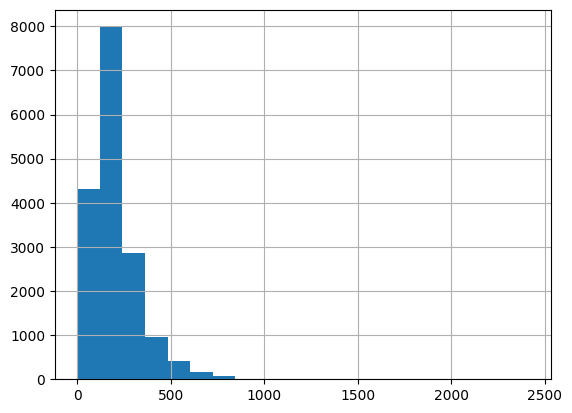

In [7]:
data['word-len'].hist(bins=20)

In [8]:
CUTOFF = int(data['word-len'].mean() + data['word-len'].std())

In [9]:
import re
data['no-punct'] = data['Lyric'].apply(lambda i: re.sub(r'[^\w\s]', '', i))
data['no-punct'] = data['no-punct'].apply(lambda i: i.lower())
data['words-split'] = data['no-punct'].apply(lambda i: re.split(' |\n', i))
data['words-split'] = data['words-split'].apply(lambda i: [j for j in i if j])

In [10]:
data['words-split'].head()

0    [saint, anger, round, my, neck, saint, anger, ...
1    [road, runner, road, runner, going, hundred, m...
2    [come, if, our, own, lives, arent, directly, a...
3    [ayy, yall, heard, about, the, good, news, yal...
4    [ill, never, be, the, same, breaking, decency,...
Name: words-split, dtype: object

In [11]:
# Normalize sequence length
data['trimmed'] = data['words-split'].apply(lambda i: i[:CUTOFF] if len(i) > CUTOFF else i)
data['padded'] = data['trimmed'].apply(lambda i: i + [''] * (CUTOFF - len(i)))

In [12]:
tqdm.pandas()
encodings = np.stack(data['padded'].progress_apply(lambda i: np.stack([vectorize(j) for j in i])))
encodings.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16797/16797 [00:25<00:00, 668.88it/s]


(16797, 329, 302)

## Model

In [13]:
import tensorflow as tf

in_size = 302

inputs = tf.keras.layers.Input((CUTOFF, in_size))
x = tf.keras.layers.Dense(in_size // 10)(inputs)
x = tf.keras.layers.Reshape((*x.shape[1:], 1))(x)
x = tf.keras.layers.Conv2D(100, 25, activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(in_size // 10, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=.1)(x)
x = tf.keras.layers.Dense(in_size // 10, activation='relu')(x)
x = tf.keras.layers.Dense(3)(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Metal device set to: Apple M1 Pro


2023-03-08 11:14:32.822580: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-08 11:14:32.822837: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 329, 302)]        0         
                                                                 
 dense (Dense)               (None, 329, 30)           9090      
                                                                 
 reshape (Reshape)           (None, 329, 30, 1)        0         
                                                                 
 conv2d (Conv2D)             (None, 305, 6, 100)       62600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 152, 3, 100)      0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 45600)             0         
                                                             

In [14]:
def normalize(inp: np.ndarray) -> np.ndarray:
    return (inp - inp.mean()) / inp.std()

valence_norm = normalize(data['valence_tags'].to_numpy())
arousal_norm = normalize(data['arousal_tags'].to_numpy())
dominance_norm = normalize(data['arousal_tags'].to_numpy())

data['valence_norm'] = valence_norm
data['arousal_norm'] = arousal_norm
data['dominance_norm'] = dominance_norm

labels = np.stack([valence_norm, arousal_norm, dominance_norm], axis=1)
labels.shape

(16797, 3)

In [ ]:
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(encodings, labels, test_size=.1)

In [16]:
model.fit(encodings, labels, validation_split=.1, batch_size=100, epochs=25)

Epoch 1/25


2023-03-08 11:15:20.715035: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-08 11:15:21.261124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - ETA: 0s - loss: 0.9847

2023-03-08 11:17:34.151784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 135s 882ms/step - loss: 0.9847 - val_loss: 1.1485
Epoch 2/25
152/152 [==============================] - 131s 861ms/step - loss: 0.9844 - val_loss: 1.1496
Epoch 3/25
152/152 [==============================] - 131s 859ms/step - loss: 0.9844 - val_loss: 1.1515
Epoch 4/25
152/152 [==============================] - 131s 860ms/step - loss: 0.9844 - val_loss: 1.1512
Epoch 5/25
152/152 [==============================] - 131s 861ms/step - loss: 0.9844 - val_loss: 1.1511
Epoch 6/25
152/152 [==============================] - 131s 860ms/step - loss: 0.9844 - val_loss: 1.1517
Epoch 7/25
152/152 [==============================] - 131s 860ms/step - loss: 0.9844 - val_loss: 1.1529
Epoch 8/25
152/152 [==============================] - 131s 862ms/step - loss: 0.9844 - val_loss: 1.1513
Epoch 9/25
152/152 [==============================] - 131s 861ms/step - loss: 0.9844 - val_loss: 1.1531
Epoch 10/25
152/152 [==============================] - 131s 862ms/step - lo


KeyboardInterrupt



In [17]:
model.save('demo-model-w2v')

INFO:tensorflow:Assets written to: demo-model-w2v/assets


INFO:tensorflow:Assets written to: demo-model-w2v/assets


In [16]:
model = tf.keras.models.load_model('demo-model-w2v')

In [24]:
test_idx = 12
to_pred = np.stack([vectorize(i) for i in data['padded'].iloc[test_idx]])
to_pred = np.expand_dims(to_pred, axis=0)

In [25]:
to_pred.shape

(1, 329, 302)

In [26]:
# def normalize_pt(pt: float, arr: np.ndarray) -> float:
#     return (pt - arr.mean()) / arr.std()
# normalize_pt(data.iloc[test_idx]['dominance_tags'], data['dominance_tags'].to_numpy())
data.iloc[test_idx]

Unnamed: 0                                                               33
lastfm_url                https://www.last.fm/music/mystikal/_/shake%2by...
track                                                          Shake Ya Ass
artist                                                             Mystikal
seeds                                                        ['aggressive']
number_of_emotion_tags                                                   11
valence_tags                                                       5.680882
arousal_tags                                                       5.751912
dominance_tags                                                     5.930882
mbid                                   bf2761fe-8b4d-4cc8-bdea-0ccda7c3fed1
spotify_id                                           1jRzdY7oUBOhrylNtiMtBD
genre                                                               hip-hop
Lyric                     Mmm! Mmm, mmm, mmm\nOooh-OOOH!\n\n[Hook - repe...
language    

In [27]:
model.predict(to_pred)

1/1 [==============================] - 0s 16ms/step


array([[-0.02039935,  0.0372753 ,  0.04638171]], dtype=float32)

In [28]:
predictions = model.predict(encodings, batch_size=100)

168/168 [==============================] - 15s 87ms/step


In [34]:
predictions[:, 0].std(), predictions[:, 1].std(), predictions[:, 2].std()

(7.450581e-09, 7.450581e-09, 7.450581e-09)

In [36]:
# import matplotlib.pyplot as plt

# rng = np.random.default_rng()
# sample = rng.integers(len(data), size=100)

# to_pred = data['padded'].iloc[sample]
# to_pred = np.stack([enc.transform(i) for i in to_pred])
# x = np.stack([i.toarray() for i in to_pred])
# pred = model.predict(x, batch_size=100)
pred = predictions

In [38]:
from sklearn.metrics import r2_score
valence_lbls = data['arousal_norm'].to_numpy()
r2_score(valence_lbls, pred[:, 1])

-0.001694765315293223

Text(0.5, 1.0, 'Valence Prediction Performance')

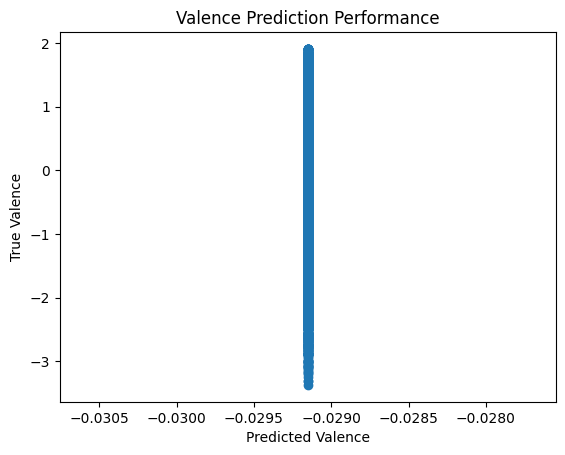

In [39]:
valence_true = data['valence_norm']
valence_pred = pred[:, 0]
plt.scatter(valence_pred, valence_true)
plt.xlabel('Predicted Valence')
plt.ylabel('True Valence')
plt.title('Valence Prediction Performance')

Text(0.5, 1.0, 'Arousal Prediction Performance')

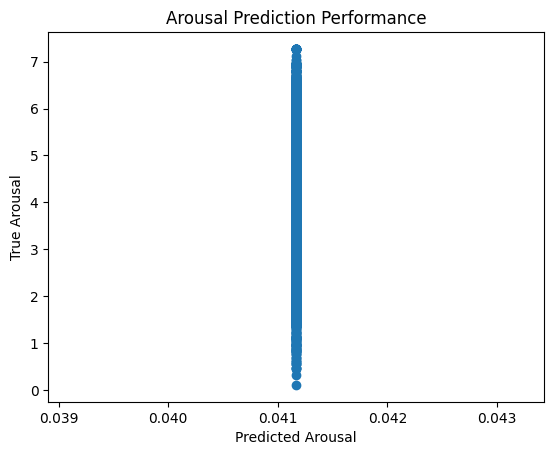

In [40]:
arousal_true = data['arousal_tags']
arousal_pred = pred[:, 1]
plt.scatter(arousal_pred, arousal_true)
plt.xlabel('Predicted Arousal')
plt.ylabel('True Arousal')
plt.title('Arousal Prediction Performance')

Text(0.5, 1.0, 'Dominance Prediction Performance')

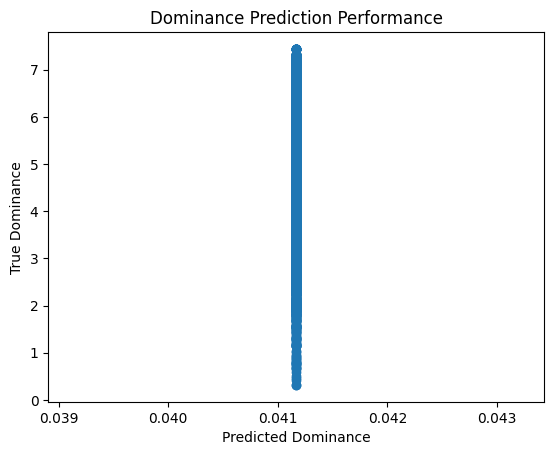

In [41]:
dominance_true = data['dominance_tags']
dominance_pred = pred[:, 2]
plt.scatter(dominance_pred, dominance_true)
plt.xlabel('Predicted Dominance')
plt.ylabel('True Dominance')
plt.title('Dominance Prediction Performance')